Nous allons tenter d'estimer BTC_Close. Pour cela, nous allons utiliser XGboost. Nous allons essayer de prédire la valeurs BTC_Close à partir des valeurs du BTC, et d'autres indicateurs (autres Altcoin, Or, actions, Forex) des jours précédents.

In [0]:
#Importation des packages

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from datetime import timedelta

import xgboost as xgb
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold 

%matplotlib inline

Nous allons tout d'abord commencer par préparer les donner. Nous allons séparer la target BTC_Low des features. Etant donné que nous nous basons sur les cours des jours précédents (on ne peut évidemment pas connaître les cours du jour même), nous allons "reculer" les features d'une journée, et ajouter une variable "nombre de jours depuis le début du dataset"(day_to_start).

In [0]:
file='https://raw.githubusercontent.com/ghassenabdedayem/AltCoins/master/data_sources/df_global_final.csv'

In [0]:
#Charger les données

data=pd.read_csv(file)
data.head()


#Créer la timeline
timeline=data.apply(lambda x: datetime.strptime(x['GOLD_Time'],"%Y-%m-%d"),axis=1)[1:]


#Ajouter une variable "nombre de jours depuis le début"
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

my_min=min(data['GOLD_Time'])
data['day_to_start']=data.apply(lambda x: days_between(x['GOLD_Time'],my_min),axis=1)


#créer un df pour conserver la timeline
time_df=pd.DataFrame({'date':timeline,'day_to_start':data['day_to_start'][1:]})

#Supprimer la colonne temporelle de data
data=data.drop('GOLD_Time',axis=1)

In [0]:
data.head()

,GOLD_USD_AM,GOLD_USD_PM,GOLD_GBP_AM,GOLD_GBP_PM,GOLD_EUR_AM,GOLD_EUR_PM,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BTC_Market_Cap,BTC_Intraday,ADA_Open,ADA_High,ADA_Low,ADA_Close,ADA_Volume,ADA_Market_Cap,ADA_Intraday,LTC_Open,LTC_High,LTC_Low,LTC_Close,LTC_Volume,LTC_Market_Cap,LTC_Intraday,EOS_Open,EOS_High,EOS_Low,EOS_Close,EOS_Volume,EOS_Market_Cap,EOS_Intraday,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,ETH_Market_Cap,...,IEF_Close,IEF_Volume,NVIDIA_Open,NVIDIA_High,NVIDIA_Low,NVIDIA_Close,NVIDIA_Volume,AMD_Open,AMD_High,AMD_Low,AMD_Close,AMD_Volume,GOOGLE_Open,GOOGLE_High,GOOGLE_Low,GOOGLE_Close,GOOGLE_Volume,GPS_Open,GPS_High,GPS_Low,GPS_Close,GPS_Volume,COCOA_Open,COCOA_High,COCOA_Low,COCOA_Close,COCOA_Volume,IBM_Open,IBM_High,IBM_Low,IBM_Close,IBM_Volume,GGTrends_values,Day_Cos,Day_Sin,Month_Cos,Month_Sin,Quarter_Cos,Quarter_Sin,day_to_start
0,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7764,7836,7515,7569,17158194786,136829391049,321,0.041416,0.042268,0.040068,0.040425,64184926,1048107282,0.002200,48.91,49.28,47.09,47.48,2678481167,3026175357,2.19,2.80,2.83,2.74,2.76,1537950803,2598670742,0.09,155,156,151,152,6565950868,16589132426,...,111.66,0.0,216.53,216.53,216.53,216.53,0.0,39.16,39.16,39.160,39.16,0.0,1304.98,1304.980,1304.98,1304.98,0.0,16.61,16.610,16.610,16.61,0.0,2512.405,2512.405,2512.405,2512.405,0.0,134.45,134.45,134.45,134.45,0.0,8.928571,0.623490,-0.781831,0.866025,-0.5,1.0,-2.449294e-16,2523
1,1456.0,1460.0,1129.55,1131.32,1323.24,1327.42,7466,7781,7460,7761,19709695456,140280108521,321,0.039227,0.042040,0.039194,0.041423,99506198,1073986624,0.002846,47.09,49.32,47.09,48.88,2944492393,3115330867,2.23,2.64,2.80,2.64,2.80,1899935358,2636173142,0.16,151,156,151,155,7503898278,16887922522,...,111.66,1798695.0,217.00,218.14,215.78,216.53,1881106.0,39.07,39.51,39.020,39.16,7526362.0,1305.50,1310.205,1303.97,1304.98,392185.0,16.91,16.930,16.570,16.61,1311527.0,2512.405,2512.405,2512.405,2512.405,0.0,133.59,134.51,133.04,134.45,773921.0,9.464286,-0.222521,-0.974928,0.866025,-0.5,1.0,-2.449294e-16,2522
2,1458.0,1455.0,1127.27,1127.35,1323.60,1321.84,7536,7730,7454,7463,19050116751,134879411013,276,0.039129,0.039990,0.038641,0.039190,60743403,1016079672,0.001349,48.00,48.55,47.02,47.06,2662459127,2998875250,1.53,2.69,2.76,2.62,2.64,1514999632,2483560320,0.14,153,156,151,151,7346531960,16496129470,...,111.66,0.0,218.24,218.24,218.24,218.24,0.0,39.41,39.41,39.410,39.41,0.0,1312.99,1312.990,1312.99,1312.99,0.0,16.91,16.910,16.910,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,133.76,133.76,133.76,133.76,0.0,10.714286,-0.900969,-0.433884,0.866025,-0.5,1.0,-2.449294e-16,2521
3,1459.8,1454.0,1134.12,1129.74,1326.23,1322.30,7220,7619,6974,7531,23991412764,136102712894,645,0.036955,0.039800,0.035783,0.039049,76841561,1012420887,0.004017,47.16,48.52,45.44,48.01,2979663352,3059223170,3.08,2.63,2.73,2.53,2.69,2247567344,2532133843,0.20,148,154,143,153,8778095308,16634910472,...,111.66,2334424.0,218.67,220.02,217.18,218.24,5314571.0,39.50,39.76,39.080,39.41,33127997.0,1315.00,1318.187,1309.63,1312.99,989345.0,17.01,17.150,16.710,16.91,0.0,2512.405,2512.405,2512.405,2512.405,0.0,135.28,135.70,133.63,133.76,0.0,11.428571,-0.900969,0.433884,0.866025,-0.5,1.0,-2.449294e-16,2520
4,1458.0,1455.0,1133.76,1131.86,1322.96,1321.11,7145,7320,7098,7218,21129505542,130429018720,222,0.036046,0.037074,0.035705,0.036993,57431470,959117573,0.001369,45.81,47.54,45.66,47.27,2659405400,3012041642,1.88,2.53,2.65,2.53,2.63,1894353525,2479535254,0.12,146,150,145,148,7648516297,16193326033,...,111.95,3578750.0,220.50,220.69,216.75,217.00,9487105.0,38.99,39.48,38.815,38.99,42706750.0,1309.86,1314.760,1305.09,1313.55,1011135.0,17.11,17.265,16.855,17.01,0.0,2512.405,2512.405,2512.405,2512.405,0.0,136.01,136.15,134.77,135.03,0.0,11.785714,-0.222521,0.974928,0.866025,-0.5,1.0,-2.449294e-16,2519


In [0]:
#Créer target et features

In [0]:
target=data.BTC_Close
target=target[1:]  #Retirer la première valeur

features=data.drop('BTC_Close',axis=1)
features=features[:-1]  #Retirer la dernières ligne

Etant donné les variations d'échelles, nous allos normaliser les features.

In [0]:
#Normalisation

scaler=MinMaxScaler()

#On conserve le day_to_date normalisé dans time_df (day_to_date est la dernière colonne)

feat_norm=scaler.fit_transform(features)

time_df['dnorm']=feat_norm[:,feat_norm.shape[1]-1]


Nous allons effectuer un premier essai avec une cross_validation. L'objective sera "reg:squarederror". Nous allons tester avec 50 rounds.

In [0]:
dnorm = xgb.DMatrix(feat_norm, label=target)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=dnorm, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Nous allons plotter les résultats.

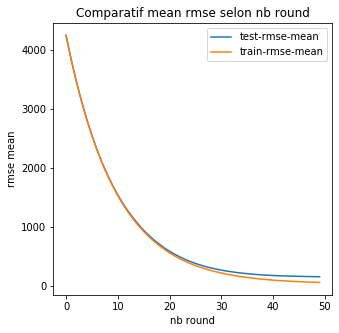

In [0]:
fig=plt.figure(figsize=(5,5))
ax1=fig.add_subplot(111)

ax1.plot(cv_results["test-rmse-mean"],label='test-rmse-mean')
ax1.plot(cv_results["train-rmse-mean"],label='train-rmse-mean')
ax1.set_ylabel('rmse mean')
ax1.set_xlabel('nb round')
ax1.legend(loc='best')
ax1.set_title('Comparatif mean rmse selon nb round');

Nous pouvons voir que la mean rmse décroît fortement jusqu'au round 20, puis plus lentement. Il ne semble pas y avoir d'overfitting, les résultats sur le test étant à peu près équivalents aux résultats sur le train.

Nous allons entraîner un modèle avec le meilleur résultat obtenu.

In [0]:
best_nrounds = cv_results.shape[0] - 1
print(best_nrounds)

49

In [0]:
X_train,X_test,y_train,y_test=train_test_split(feat_norm,target,test_size=0.2)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


gbdt = xgb.train(params, dtrain, best_nrounds)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Nous allons regarder l'importance des variables dans ce modèle

In [0]:
print('Alors que nous avions initialement ',len(features.columns)," variables, le modèle n'en a conservées que ",len(gbdt.get_fscore()))

Alors que nous avions initialement  172  variables, le modèle n'en a conservées que  145


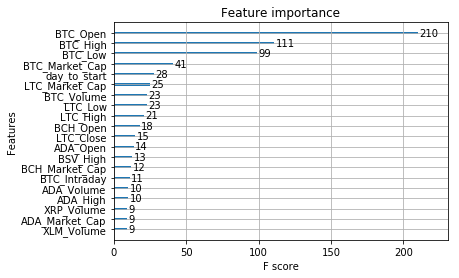

In [0]:
#Regarder l'importance des variables

gbdt.get_fscore()
mapper = {'f{0}'.format(i): v for i, v in enumerate(features.columns)}
mapped = {mapper[k]: v for k, v in gbdt.get_fscore().items()}
mapped
xgb.plot_importance(mapped,max_num_features=20);

Sans surprise, les variables relatives au BTC du jour précédent sont les plus importantes.

In [0]:
#Regarder les prédictions

In [0]:
ypred = gbdt.predict(dtest)

In [0]:
diff=y_test-ypred
diff.describe()

count     506.000000
mean       19.279324
std       181.267594
min     -1102.164062
25%        -5.634171
50%         3.738251
75%        27.996948
max      2474.737305
Name: BTC_Close, dtype: float64

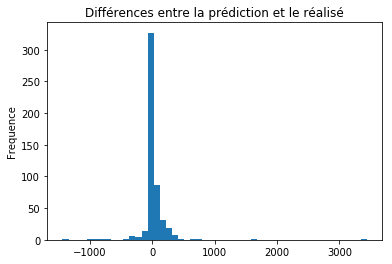

In [0]:
plt.hist(diff,bins=50)
plt.gca().set(title='Différences entre la prédiction et le réalisé', ylabel='Frequence');

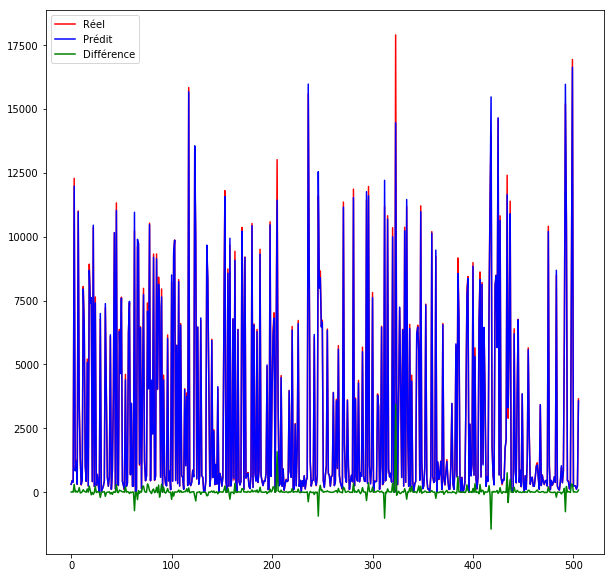

In [0]:
x_axis=range(0,len(y_test))

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.plot(x_axis,y_test,color='red',label='Réel')
ax.plot(x_axis,ypred,color='blue',label='Prédit')
ax.plot(x_axis,diff,color='green',label='Différence')
ax.legend(loc='best');

In [0]:
#percent_diff=abs(diff/y_test*100)
#percent_diff.describe()

In [0]:

#plt.hist(percent_diff,bins=50)
#plt.gca().set(title='Différences entre la prédiction et le réalisé en %(valeur absolue)', ylabel='Frequence');

Nous allons essayer d'améliorer ce score en choisissant les meilleurs hypermapramètres. Pour cela, nous allons utiliser une grid_search.

In [0]:
from xgboost import XGBRegressor

estimator = XGBRegressor(
    objective= 'reg:squarederror',
    nthread=4,
    seed=42
)


params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
parameters = {
    'max_depth': range (2, 6, 1),
    'colsample_bytree': np.arange(0.1, 0.4,0.1),
    'alpha': np.arange(1,10,1),
    'learning_rate': np.arange(0.01, 0.1,0.01)
}

In [0]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'neg_mean_squared_error',
    n_jobs = 5,
    cv = 5,
    verbose=True
)

In [0]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   16.8s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.1min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  9.9min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed: 14.3min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed: 19.8min


In [0]:
grid_search.best_estimator_

XGBRegressor(alpha=4, base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.09, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
       objective='reg:squarederror', random_state=42, reg_alpha=4,
       reg_lambda=1, scale_pos_weight=1, seed=42, subsample=1,
       tree_method=None, validate_parameters=False, verbosity=None)

In [0]:
results = pd.DataFrame(grid_search.cv_results_)

C:\Users\legea\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\legea\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\legea\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args

In [0]:
results.mean_train_score.describe()

count    1.296000e+03
mean    -4.399069e+05
std      1.008738e+06
min     -3.685341e+06
25%     -1.155964e+05
50%     -1.769838e+04
75%     -4.505370e+03
max     -3.599165e+02
Name: mean_train_score, dtype: float64

In [0]:
ypred_rs=grid_search.predict(X_test)

In [0]:
diff_rs=y_test-ypred_rs
diff_rs.describe()

count     506.000000
mean       39.594671
std       116.317719
min         0.013977
25%         3.054226
50%         6.287964
75%        30.594482
max      1872.414062
Name: BTC_Close, dtype: float64

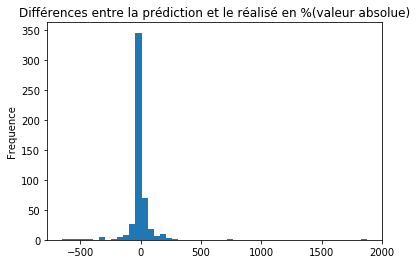

In [0]:
plt.hist(diff_rs,bins=50)
plt.gca().set(title='Différences entre la prédiction et le réalisé en %(valeur absolue)', ylabel='Frequence');

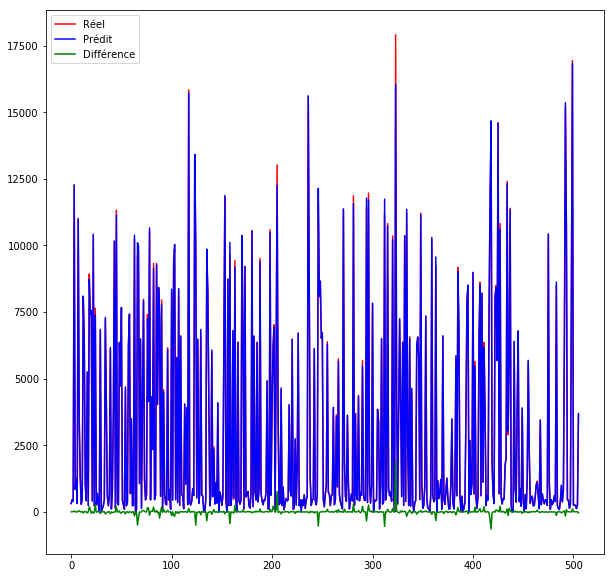

In [0]:
x_axis=range(0,len(y_test))

fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.plot(x_axis,y_test,color='red',label='Réel')
ax.plot(x_axis,ypred_rs,color='blue',label='Prédit')
ax.plot(x_axis,diff_rs,color='green',label='Différence')
ax.legend(loc='best');

On peut voir, visuellement, que le résultat a l'air meilleur.

In [0]:
df_diff=pd.DataFrame({'diff':abs(diff).describe(),'diff_rs':abs(diff_rs).describe()})

In [0]:
df_diff

,diff,diff_rs
count,506.000000,506.000000
mean,73.044008,39.594671
std,210.932718,116.317719
min,0.085938,0.013977
25%,5.214266,3.054226
50%,15.949051,6.287964
75%,59.624023,30.594482
max,3440.396484,1872.414062


On peut voir que la différence moyenne sur la prédiction est beaucoup plus faible après la grid_search. On peut aussi voir que les différence minimum et maximum se sont beaucoup resserrées.

La grid_search a donc amené une grosse amélioration sur le résultat.

In [0]:
data['BTC_Low'].describe()

count     2530.000000
mean      2781.825692
std       3591.009426
min          0.000000
25%        313.000000
50%        636.000000
75%       5126.250000
max      18974.000000
Name: BTC_Low, dtype: float64